In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

from tqdm import tqdm
from torch.utils.data import Dataset

import os
import tifffile
import trackpy as tp
import warnings
import logging
import time

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    torch.cuda.empty_cache()
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3080
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Load Data

In [3]:
def get_PSF_frame(movie_frame, x, y, frame_size, keep_edges=False):
    half_frame = int(frame_size/2)
    int_x = round(x); int_y = round(y)
    lower_x = int_x - half_frame
    lower_y = int_y - half_frame
    upper_x = int_x + half_frame + 1
    upper_y = int_y + half_frame + 1
    upper_limit_x = movie_frame.shape[1]
    upper_limit_y = movie_frame.shape[0]
    if keep_edges:
        if lower_x < 0:
            lower_x = 0
        if lower_y < 0:
            lower_y = 0
        if upper_x > upper_limit_x:
            upper_x = upper_limit_x
        if upper_y > upper_limit_y:
            upper_y = upper_limit_y
    else:
        if lower_x < 0 or lower_y < 0 or upper_x > upper_limit_x or upper_y > upper_limit_y:
            return False
    return np.array(movie_frame)[lower_y:upper_y, lower_x:upper_x]

def get_PSF_frames(movie, minmass=2000, separation=3, diameter=7, frame_size=13, percentile=0.9, to_plot=False, movie_frames=True, dpi=100):
    if type(movie_frames) == bool:
        movie_frames = range(len(movie))
    
    # Initialize an empty list to store the PSF frames
    PSF_frames = []

    # Loop through each frame in the movie
    for i in movie_frames:
        # Perform localization on the frame
        full_frame = tp.locate(movie[i], diameter=diameter, 
                        minmass=minmass, max_iterations=10,
                        separation=separation, percentile=percentile)  # Adjust the minmass parameter as needed

        # Plot the frame with the identified features
        if to_plot:
            fig, ax = plt.subplots(1, dpi=dpi)
            ax.imshow(movie[i], cmap='gray')

        # Draw a box around each identified feature
        for index, row in full_frame.iterrows():
            if to_plot:
                rect = patches.Rectangle((row['x']-int(frame_size/2), row['y']-int(frame_size/2)), frame_size, frame_size, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
            PSF_frame = get_PSF_frame(movie[i], row['x'], row['y'], frame_size)
            if type(PSF_frame) == bool:
                continue
            PSF_frames.append(PSF_frame)
        if to_plot:
            plt.title(f'Full Frame {i}')
            plt.show()

    # Convert the list of frames to a numpy array
    PSF_frames = np.array(PSF_frames)
    return PSF_frames

def get_PSF_frames_movie_list(movies, minmass=2000, separation=3, diameter=7, frame_size=13, percentile=0.9):
    first = True
    for movie in movies:
        if first:
            PSF_list = get_PSF_frames(movie, minmass, separation, diameter, frame_size, percentile)
            first = False
        else:
            PSF_list = np.concatenate((PSF_list, get_PSF_frames(movie, minmass, separation, diameter, frame_size, percentile)))
    return PSF_list

def show_PSFs(PSF_frames, random=True):
    print(PSF_frames.shape)
    num_PSFs = 15
    if not random:
        random_seed = 1 # random seed for reproducibility
        np.random.seed(random_seed)
    PSF_indices = np.random.choice(PSF_frames.shape[0], size=num_PSFs, replace=False)
    image_list = PSF_frames[PSF_indices]

    # Creating a 2x5 subplot grid
    fig, axes = plt.subplots(3, 5, figsize=(10, 4), dpi=150)

    # Flattening the 2D array of axes to a 1D array
    axes = axes.flatten()

    # Iterating over each image and corresponding axis
    for i in range(len(axes)):
        # Displaying the image on the corresponding axis
        axes[i].imshow(image_list[i], cmap='gray')
        axes[i].axis('off')

    plt.suptitle("Examples of PSF Frames", fontsize=24)
    plt.tight_layout()
    plt.show()

def load_tif_movies(folder_path):
    movies = []
    logger = logging.getLogger('tifffile')
    prev_level = logger.getEffectiveLevel()  # get the current logging level
    logger.setLevel(logging.ERROR)  # set level to ERROR, only ERROR level and above will be shown
    try:
        for filename in os.listdir(folder_path):
            # Check if the current file is a .tif file
            if filename.endswith('.tif'):
                # Construct the full filepath by joining the directory path and the filename
                filepath = os.path.join(folder_path, filename)
                movies.append(tifffile.imread(filepath))
    finally:
        logger.setLevel(prev_level)  # reset the logging level to its previous state
    return movies


## Tons of Data for Training

In [4]:
A647_movies = load_tif_movies('Raw Data\A647')
CF660_movies = load_tif_movies('Raw Data\CF660c')
print(len(A647_movies), len(CF660_movies))

KeyboardInterrupt: 

In [5]:
minmass = 3500
separation = 15
diameter = 9
frame_size = 19
percentile =99.5
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", category=UserWarning)
#     A647_PSFs = get_PSF_frames_movie_list(A647_movies, minmass, separation, diameter, frame_size, percentile)

In [5]:
# with open('PSF Frames\A647_combined_PSFs.npy', 'wb') as f:
#     np.save(f, A647_PSFs)
with open('PSF Frames\A647_combined_PSFs.npy', 'rb') as f:
    A647_PSFs = np.load(f)

(199604, 19, 19)


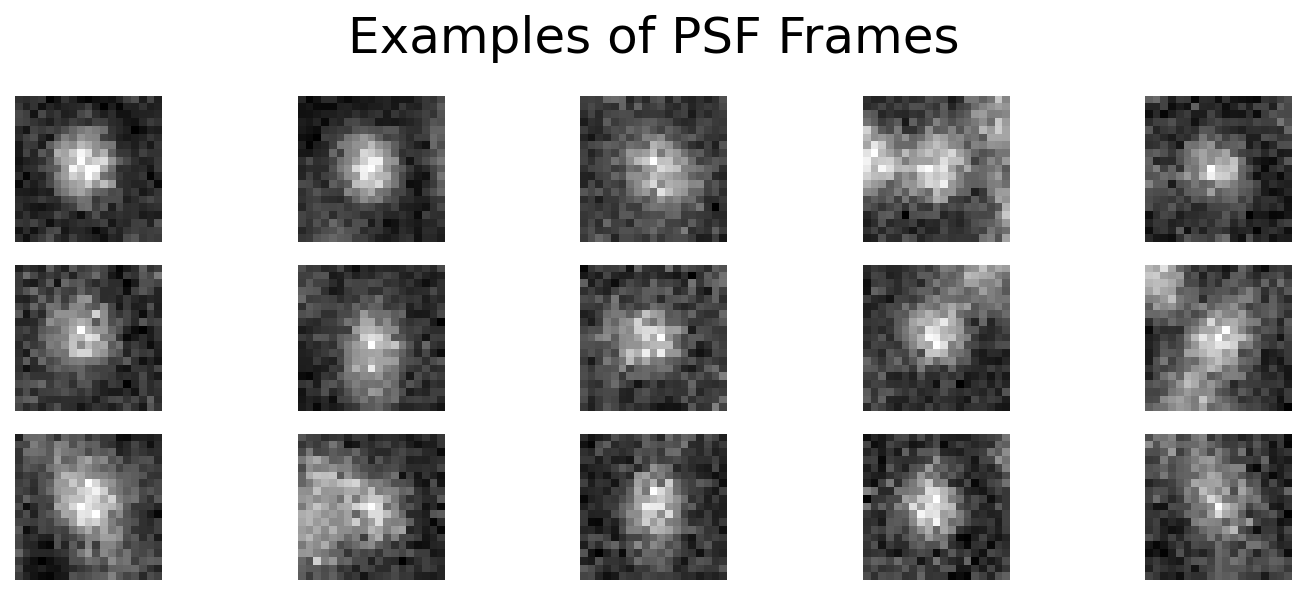

In [7]:
show_PSFs(A647_PSFs)

In [8]:
minmass = 3500
separation = 15
diameter = 9
frame_size = 19
percentile =99.5
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    CF660_PSFs = get_PSF_frames_movie_list(CF660_movies, minmass, separation, diameter, frame_size, percentile)

In [6]:
# with open('PSF Frames\CF660c_combined_PSFs.npy', 'wb') as f:
#     np.save(f, CF660_PSFs)
with open('PSF Frames\CF660c_combined_PSFs.npy', 'rb') as f:
    CF660_PSFs = np.load(f)

(99769, 19, 19)


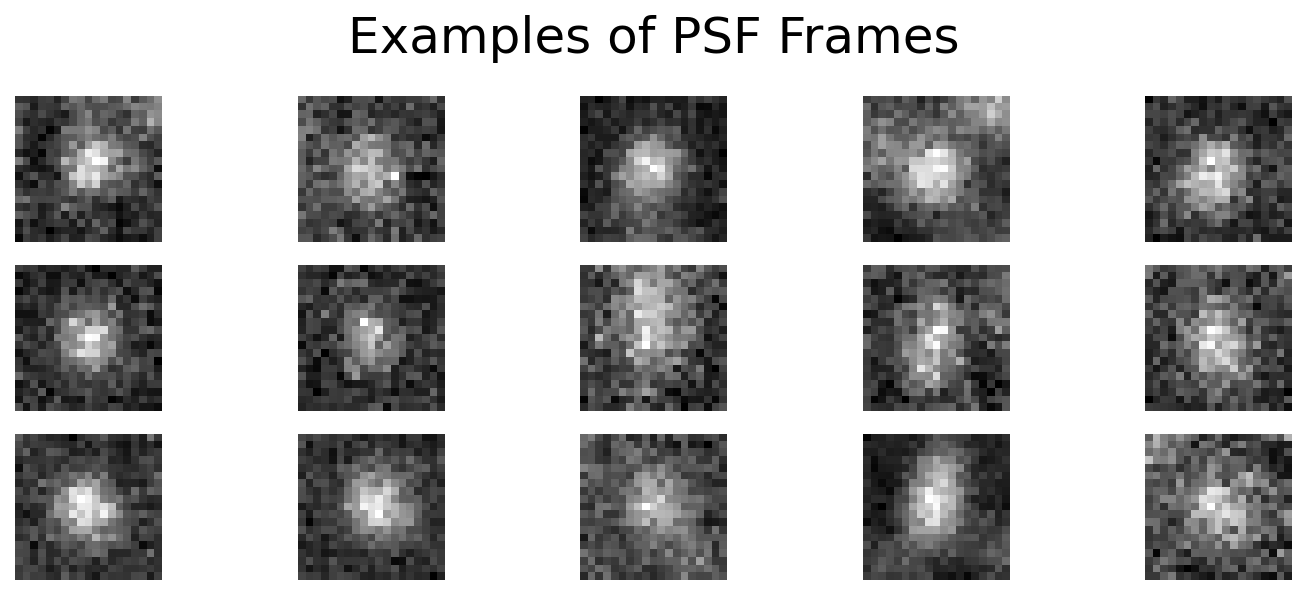

In [10]:
show_PSFs(CF660_PSFs)

In [7]:
# Assign data to classes
classes = {'A': "A647", 'B': "CF660c"}
A_raw = A647_PSFs
B_raw = CF660_PSFs

# Reduce the size of the larger dataset
if len(A_raw) < len(B_raw):
    B_raw = B_raw[np.random.choice(range(len(B_raw)), len(A_raw))]
else:
    A_raw = A_raw[np.random.choice(range(len(A_raw)), len(B_raw))]

# Combine, create labels, and reshuffle all
all_data = np.concatenate((A_raw, B_raw)).astype(np.int32)
labels = np.concatenate((np.zeros(len(A_raw)), np.ones(len(B_raw))))

random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_indices = np.random.choice(np.arange(len(all_data)), size=len(all_data), replace=False)

In [8]:
class PSFDataset(Dataset):
    def __init__(self, train, split=0.85, normalize=False):
        if train:
            self.images = torch.from_numpy(all_data[all_indices[:int(split*len(all_indices))]]).unsqueeze(1).cuda()
            self.labels = torch.from_numpy(labels[all_indices[:int(split*len(all_indices))]]).long().cuda()
        else:
            self.images = torch.from_numpy(all_data[all_indices[int(split*len(all_indices)):]]).unsqueeze(1).cuda()
            self.labels = torch.from_numpy(labels[all_indices[int(split*len(all_indices)):]]).long().cuda()

        # Normalize the images if requested
        if normalize:
            self.images = self.normalize_images(self.images)

    def normalize_images(self, images):
        # Convert to float if necessary
        if images.dtype != torch.float32:
            images = images.float()
            
        norm = torch.norm(images.view(images.shape[0], -1), dim=1).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        normalized_images = images / norm
        return normalized_images

    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx].float(), self.labels[idx]


# make training set
PSF_training = PSFDataset(True)
PSF_training_normalized =  PSFDataset(True, normalize=True)
# make testing set
PSF_testing = PSFDataset(False)
PSF_testing_normalized =  PSFDataset(False, normalize=True)

print(len(PSF_training))
print(len(PSF_testing))

169607
29931


## Good Data for Post-Training Testing

In [13]:
# Load the TIFF movie for Good Data
A647_movie = tifffile.imread('Raw Data\Good Data\A647-GoatAntiMouse-No1CG-100EMG-50ms_28mW.tif')
CF660_movie = tifffile.imread('Raw Data\Good Data\CF660c-GaM_No1CG_100EMG_50ms_28mW647_0mW405.tif')
print(f"A647 Frame Count: {len(A647_movie)}")
print(f"CF660 Frame Count: {len(CF660_movie)}")

<tifffile.TiffTag 5033 @530844> coercing invalid ASCII to bytes


<tifffile.TiffTag 5033 @530844> coercing invalid ASCII to bytes


A647 Frame Count: 100
CF660 Frame Count: 500


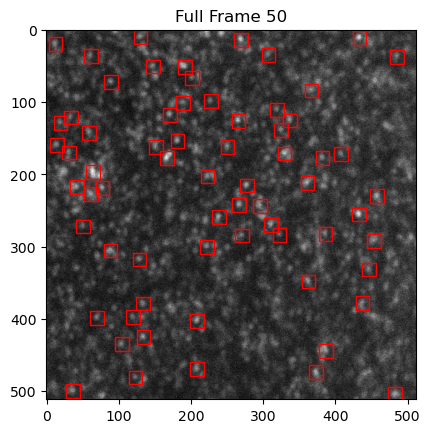

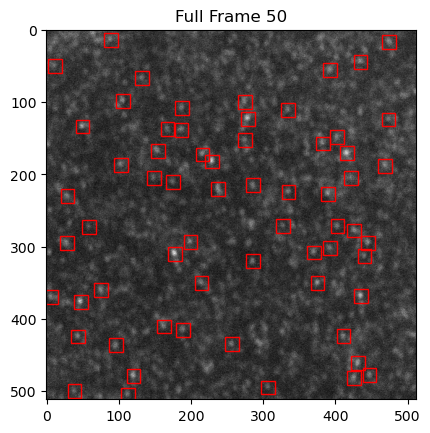

In [19]:
minmass = 3500
separation = 15
diameter = 9
frame_size = 19
percentile =99.5
indices = [50]

A647_PSF_frames = get_PSF_frames(A647_movie, minmass, separation, diameter, frame_size, percentile, to_plot=True, movie_frames=indices)
# A647_PSF_frames = get_PSF_frames(A647_movie, minmass, separation, diameter, frame_size, percentile, to_plot=False, movie_frames=True)
CF660_PSF_frames = get_PSF_frames(CF660_movie, minmass, separation, diameter, frame_size, percentile, to_plot=True, movie_frames=indices)
# CF660_PSF_frames = get_PSF_frames(CF660_movie, minmass, separation, diameter, frame_size, percentile, to_plot=False, movie_frames=True)

In [9]:
# with open('PSF Frames\A647_good_PSFs.npy', 'wb') as f:
#     np.save(f, A647_PSF_frames)
# with open('PSF Frames\CF660c_good_PSFs.npy', 'wb') as f:
#     np.save(f, CF660_PSF_frames)
with open('PSF Frames\A647_good_PSFs.npy', 'rb') as f:
    A647_PSF_frames = np.load(f)
with open('PSF Frames\CF660c_good_PSFs.npy', 'rb') as f:
    CF660_PSF_frames = np.load(f)

(6598, 19, 19)


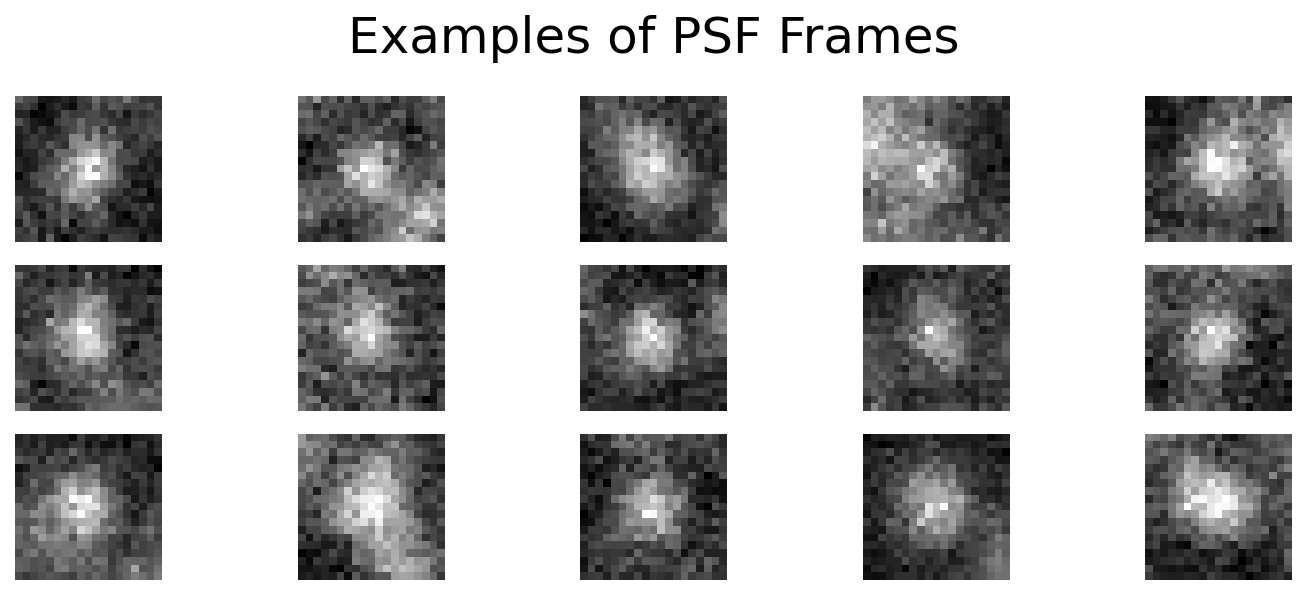

(27518, 19, 19)


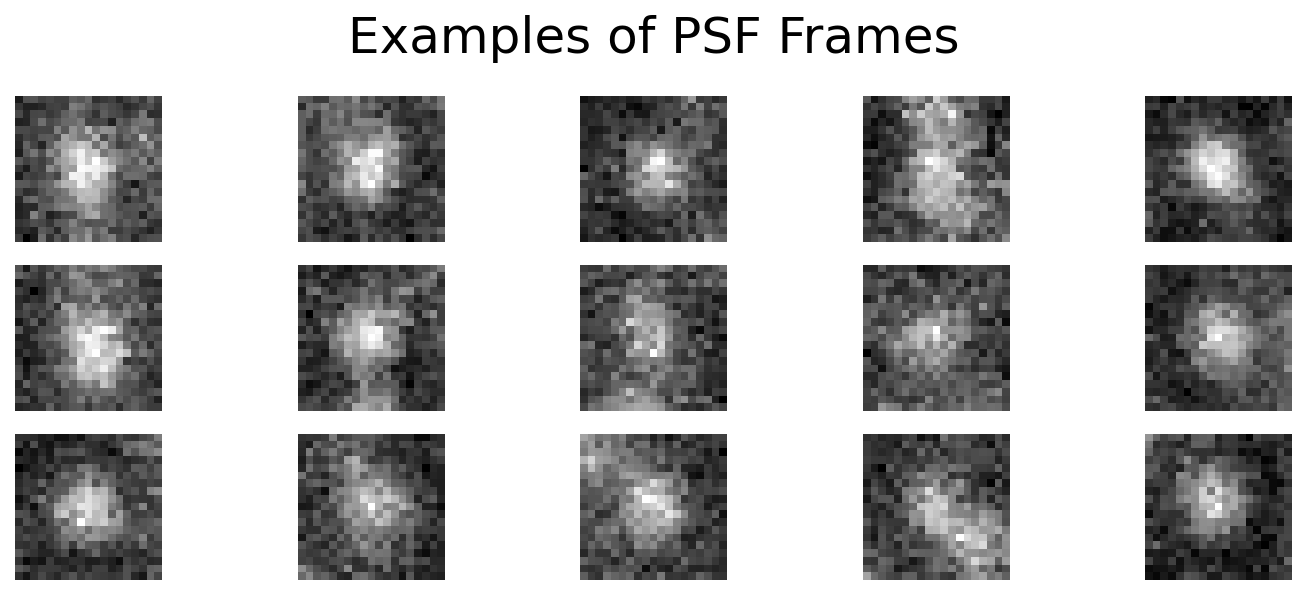

In [15]:
show_PSFs(A647_PSF_frames)
show_PSFs(CF660_PSF_frames)

In [10]:
# Assign data to classes
classes = {'A': "A647", 'B': "CF660c"}
A_raw = A647_PSF_frames
B_raw = CF660_PSF_frames

# Reduce the size of the larger dataset
if len(A_raw) < len(B_raw):
    B_raw = B_raw[np.random.choice(range(len(B_raw)), len(A_raw))]
else:
    A_raw = A_raw[np.random.choice(range(len(A_raw)), len(B_raw))]

# Combine, create labels, and reshuffle all
all_data = np.concatenate((A_raw, B_raw)).astype(np.int32)
labels = np.concatenate((np.zeros(len(A_raw)), np.ones(len(B_raw))))

random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_indices = np.random.choice(np.arange(len(all_data)), size=len(all_data), replace=False)

In [11]:
# make testing set
PSF_good_testing = PSFDataset(True, split=1)
PSF_good_testing_normalized = PSFDataset(True, split=1, normalize=True)
print(len(PSF_good_testing))

13196


# Model Code

## Function Definitions

In [146]:
# model code for simple convolutional nerual network followed by fully connected layers
class ClassifierModel(nn.Module):
    # constructor
    def __init__(self, channel_widths, linear_sizes, kernel, pooling, nonlinearity=nn.ReLU()):
        super(ClassifierModel, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.channel_widths = channel_widths
        self.linear_sizes = linear_sizes
        self.kernel = kernel
        self.pooling = pooling
        self.nonlinearity = nonlinearity
        
        layers = []
        for i in range(len(channel_widths)-2):
            layers.append(nn.Conv2d(channel_widths[i], channel_widths[i+1],
                                    kernel_size=kernel, padding=2, stride=1, bias=True))
            layers.append(nonlinearity)
        layers.append(nn.Conv2d(channel_widths[-2], channel_widths[-1],
                                    kernel_size=kernel, padding=2, stride=1, bias=True))
        self.backbone = nn.Sequential(*layers)
        self.global_pooling = pooling
        self.pool_size = pooling.output_size[0]*pooling.output_size[1]

        # Defining the fully connected layers
        fc_layers = []
        in_features = channel_widths[-1]*self.pool_size
        for size in linear_sizes:
            fc_layers.append(nn.Linear(in_features, size))
            fc_layers.append(nonlinearity)
            in_features = size
        self.fully_connected = nn.Sequential(*fc_layers)

        self.linear = nn.Linear(in_features, 2)  # score each class to obtain logits\
        self.to(self.device)
        
        # Initialize lists to store performance metrics
        self.train_losses = []
        self.train_accs = []
        self.val_losses = []
        self.val_accs = []
        self.best_val_accuracy = 0
        self.best_model_state_dict = None
        self.epochs_trained = 0
        self.training_parameter_history = []
        self.training_time = 0
        
    # forward pass
    def forward(self, x):
        x = x.to(self.device)
        B = x.size(0)
        features = self.backbone(x)
        pooled_features = self.global_pooling(features)
        pooled_features = pooled_features.view(B, -1)
        fc_output = self.fully_connected(pooled_features)
        logits = self.linear(fc_output)
        return logits
    
    # function to record performance metrics
    def record_metrics(self, train_loss, train_acc, val_loss, val_acc):
        self.train_losses.append(train_loss)
        self.train_accs.append(train_acc)
        self.val_losses.append(val_loss)
        self.val_accs.append(val_acc)
    
    # Get validation stats
    def validate(self, dataloader, criterion):
        val_loss = 0
        val_acc = 0
        # set model to eval mode (again, unnecessary here but good practice)
        self.eval()
        # don't compute gradients since we are not updating the model, saves a lot of computation
        with torch.no_grad():
            for images, targets in dataloader:
                images, targets = images.to(self.device), targets.to(self.device)
                class_logits = self(images)
                loss = criterion(class_logits, targets)
                val_loss += loss.item()
                val_acc += (class_logits.data.max(1)[1]).eq(targets).sum().item()
        return val_loss, val_acc

    # Main training function
    def train_model(self, all_data, training_indices, validation_indices, config, verbose=True, printouts=20):
        # unpack configuration parameters
        lr = config['lr'] # learning rate
        n_epochs = config['n_epochs'] # number of passes (epochs) through the training data
        batch_size = config['batch_size']
        self.training_parameter_history.append({'Epochs Scheduled': n_epochs, 'Learning Rate': lr, 'Batch Size': batch_size, 'Epochs Completed': 0, 
                                                'Training Indices': len(training_indices), 'Validation Indices': len(validation_indices), 'Training Time (s)': 0})
        if printouts > n_epochs: printouts = n_epochs
        previous_epochs = self.epochs_trained

        # set up optimizer and loss function
        optimizer = torch.optim.SGD(self.parameters(), lr=lr, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()
        
        # set up dataloaders
        train_sampler = torch.utils.data.SubsetRandomSampler(training_indices)
        val_sampler = torch.utils.data.SubsetRandomSampler(validation_indices)
        trainloader = torch.utils.data.DataLoader(all_data, batch_size=batch_size, sampler=train_sampler)
        valloader = torch.utils.data.DataLoader(all_data, batch_size=batch_size, sampler=val_sampler)
        
        try:
            for n in range(n_epochs):
                # set model to training mode (unnecessary for this model, but good practice)
                self.train()
                epoch_loss = 0
                epoch_acc = 0
                epoch_start = time.time()
                for images, targets in trainloader:
                    images, targets = images.to(self.device), targets.to(self.device)
                    optimizer.zero_grad() # zero out gradients
                    class_logits = self(images)
                    loss = criterion(class_logits, targets)
                    loss.backward() # backpropagate to compute gradients
                    optimizer.step() # update parameters using stochastic gradient descent
                    # update epoch statistics
                    epoch_loss += loss.item() # batch loss
                    epoch_acc += (class_logits.data.max(1)[1]).eq(targets).sum().item() # number of correct predictions
                    
                # validation
                epoch_loss /= len(trainloader)
                epoch_acc /= len(training_indices)
                val_loss, val_acc = self.validate(valloader, criterion)
                val_loss /= len(valloader)
                val_acc /= len(validation_indices)
                
                # log epoch information
                self.record_metrics(epoch_loss, epoch_acc, val_loss, val_acc)
                
                # save best model's state dict, if necessary
                if val_acc > self.best_val_accuracy:
                    self.best_val_accuracy = val_acc
                    self.best_model_state_dict = copy.deepcopy(self.state_dict())
                
                if verbose and (n+1) % (int(n_epochs/printouts)) == 0:
                    print('Epoch {}/{}: (Train) Loss = {:.4e}, Acc = {:.4f}, (Val) Loss = {:.4e}, Acc = {:.4f}'.format(
                        n + 1 + previous_epochs,
                        n_epochs + previous_epochs,
                        epoch_loss,
                        epoch_acc,
                        val_loss,
                        val_acc))
                self.epochs_trained += 1
                self.training_parameter_history[-1]['Epochs Completed'] += 1
                epoch_time = time.time() - epoch_start
                self.training_time += epoch_time
                self.training_parameter_history[-1]['Training Time (s)'] += epoch_time
        except KeyboardInterrupt:
            print("Training interrupted. Stopping after completing {} epochs of {} planned.".format(self.epochs_trained-previous_epochs, n_epochs))
        return

    # function to plot training performance metrics
    def plot_model_results(self):
        plt.figure(figsize=(15, 10))
        plt.subplot(221)
        plt.semilogy(self.train_losses, color='royalblue')
        plt.xlabel('Epoch')
        plt.title('Training loss')
        plt.grid(True)
        plt.subplot(222)
        plt.plot(self.train_accs, color='darkorange')
        plt.xlabel('Epoch')
        plt.title('Training accuracy')
        plt.grid(True)
        plt.subplot(223)
        plt.plot(self.val_losses, color='royalblue')
        plt.xlabel('Epoch')
        plt.title('Validation loss')
        plt.grid(True)
        plt.subplot(224)
        plt.plot(self.val_accs, color='darkorange')
        plt.xlabel('Epoch')
        plt.title('Validation accuracy')
        plt.grid(True)

    # Test different confidence treshold results on accuracy
    def test_with_thresholds(self, model, dataset, thresholds=np.arange(0.5, 1, 0.01)):
        # test model on withheld test data
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128)
        model.eval()
        
        all_probs = []
        all_targets = []
        
        with torch.no_grad():
            for images, targets in dataloader:
                images, targets = images.to(self.device), targets.to(self.device)
                class_probs = torch.nn.functional.softmax(model(images), dim=1)
                all_probs.extend(class_probs.tolist())
                all_targets.extend(targets.tolist())

        results = []
        for threshold in thresholds:
            correct_predictions = 0
            total_predictions = 0
            rejected_predictions = 0

            for i in range(len(all_probs)):
                max_prob = max(all_probs[i])
                predicted_class = all_probs[i].index(max_prob)
                if max_prob >= threshold:
                    total_predictions += 1
                    if predicted_class == all_targets[i]:
                        correct_predictions += 1
                else:
                    rejected_predictions += 1

            test_acc = correct_predictions / total_predictions if total_predictions > 0 else 0
            rejection_ratio = rejected_predictions / len(all_targets)
            results.append((threshold, test_acc, rejection_ratio))
        
        return results

    # Plot results from 'test_with_thresholds'
    def plot_confidence_thresholding(self, datasets, thresholds=np.arange(0.5, 1, 0.01), use_best_model=True, colors=['orange', 'blue', 'green', 'red', 'black']):
        if use_best_model:
            model_state_dict = self.best_model_state_dict
        else:
            model_state_dict = self.state_dict()
        # load the state dict into a new instance of the model for testing
        model = ClassifierModel(self.channel_widths, self.linear_sizes, self.kernel, self.pooling, self.nonlinearity)
        model.load_state_dict(model_state_dict)
        model = model.to(self.device)

        plt.figure()
        for i in range(len(datasets)):
            dataset = datasets[i]
            results = np.array(self.test_with_thresholds(model, dataset[1], thresholds))
            plt.plot(results[:, 0], results[:, 1], color=colors[i], label = dataset[0] + ': Accuracy')
            plt.plot(results[:, 0], results[:, 2], color=colors[i], linestyle='--', label = dataset[0] + ': Rejection Ratio')
        plt.legend()
        plt.yticks(np.arange(0, 1, 0.05), minor=True)
        plt.yticks(np.arange(0, 1.1, 0.1), minor=False)

        plt.grid(True, which='major')
        plt.grid(True, which='minor', ls='--')
        plt.ylabel("Accuracy/Rejection Ratios")
        plt.xlabel("Confidence Threshold")
        plt.title("Model Accuracy with Confidence Thresholding")
        plt.grid
        plt.show()

    def confidence_histogram(self, dataset):
        # Get the model's predictions on the dataset
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128)
        self.eval()

        confidences = []

        with torch.no_grad():
            for images, targets in dataloader:
                class_probs = torch.nn.functional.softmax(self(images), dim=1)

                # High confidence for class A (label 0) will be close to 1
                # and high confidence for class B (label 1) will be close to 0
                confidence_score = 1 - class_probs[:, 1]

                confidences.extend(confidence_score.tolist())

        # Plot the histogram
        plt.hist(confidences, bins=20, range=(0, 1), alpha=0.7)
        plt.title("Confidence Histogram")
        plt.xlabel("Confidence Score")
        plt.ylabel("Frequency")
        plt.show()

    def plot_classification_results(self, dataset):
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128)
        self.eval()
        
        correct_counts = {0: 0, 1: 0}
        total_counts = {0: 0, 1: 0}

        with torch.no_grad():
            for images, targets in dataloader:
                images, targets = images.to(self.device), targets.to(self.device)
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                
                for label in [0, 1]:
                    correct_counts[label] += ((predicted == targets) & (targets == label)).sum().item()
                    total_counts[label] += (targets == label).sum().item()

        # Calculate the percentages
        percentages = {label: correct / total * 100 for label, (correct, total) in enumerate(zip(correct_counts.values(), total_counts.values()))}
        
        # Plot the bar chart
        labels = ['Class A', 'Class B']
        correct = [percentages[0], percentages[1]]
        incorrect = [100 - percentages[0], 100 - percentages[1]]
        
        x = np.arange(len(labels))  # the label locations
        width = 0.35  # the width of the bars
        
        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width/2, correct, width, label='Correct')
        rects2 = ax.bar(x + width/2, incorrect, width, label='Incorrect')
        
        ax.set_xlabel('Classes')
        ax.set_ylabel('Percentage')
        ax.set_title('Classification Results')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()
        
        plt.show()
    
    # Save everything about the model so it can be reloaded later
    def save_model(self, PATH):
        checkpoint = {
            'model_state_dict': self.state_dict(),
            'train_losses': self.train_losses,
            'train_accs': self.train_accs,
            'val_losses': self.val_losses,
            'val_accs': self.val_accs,
            'best_val_accuracy': self.best_val_accuracy,
            'epochs_trained': self.epochs_trained,
            'training_parameter_history': self.training_parameter_history,
            'training_time': self.training_time,
            'channel_widths': self.channel_widths,
            'linear_sizes': self.linear_sizes,
            'kernel': self.kernel,
            'pooling': self.pooling,
            'nonlinearity': type(self.nonlinearity),  # save the type of nonlinearity
            'best_model_state_dict': self.best_model_state_dict,
        }
        torch.save(checkpoint, PATH)

    # Reload everything in the model from a file
    @classmethod
    def load_model(cls, PATH):
        checkpoint = torch.load(PATH)
        model = cls(
            channel_widths=checkpoint['channel_widths'],
            linear_sizes=checkpoint['linear_sizes'],
            kernel=checkpoint['kernel'],
            pooling=checkpoint['pooling'],
            nonlinearity=checkpoint['nonlinearity'](),  # instantiate the nonlinearity
        )
        model.load_state_dict(checkpoint['model_state_dict'])
        model.train_losses = checkpoint['train_losses']
        model.train_accs = checkpoint['train_accs']
        model.val_losses = checkpoint['val_losses']
        model.val_accs = checkpoint['val_accs']
        model.best_val_accuracy = checkpoint['best_val_accuracy']
        model.epochs_trained = checkpoint['epochs_trained']
        model.training_parameter_history = checkpoint['training_parameter_history']
        model.training_time = checkpoint['training_time']
        model.best_model_state_dict = checkpoint['best_model_state_dict']

        model.to(model.device)
        return model


## Training and Testing

### Model 12

In [122]:
# metrics visualization

# data
# you can try playing around with more or less training data
N_training_examples = 5000 # 100 examples per class
N_validation_examples = 1000 # 100 examples per class
random_seed = 2 # random seed for reproducibility
np.random.seed(random_seed)
all_train_indices = np.random.choice(np.arange(len(PSF_training)),
                               size=2*N_training_examples+N_validation_examples)
# Make two unique training/validation sets for change partway through training if desired
all_train_indices_1 = all_train_indices[:int(len(all_train_indices)/2)]
all_train_indices_2 = all_train_indices[int(len(all_train_indices)/2):]
training_indices_1 = all_train_indices_1[:N_training_examples]
validation_indices_1 = all_train_indices_1[N_training_examples:]
training_indices_2 = all_train_indices_2[:N_training_examples]
validation_indices_2 = all_train_indices_2[N_training_examples:]


In [ ]:

# configuration parameters, you can play around with these
pooling = 'max' # 'max' or 'mean'

if pooling == 'max':
    pool_fcn = nn.AdaptiveMaxPool2d((1, 1))
else:
    pool_fcn = nn.AdaptiveAvgPool2d((1, 1))
# model
# your model will have length(channel_widths)-1 layers
channel_widths = [1, 128, 128, 256, 256, 512] # must start with a 1 and be at least length--2
linear_sizes = [1024, 64]
kernel = 3
model_12 = ClassifierModel(channel_widths, linear_sizes, kernel, pool_fcn)

In [142]:
config = {'lr': 1e-5,
          'n_epochs': 50,
          'batch_size': 512}
verbose = True # print metrics during training, False for no printing
model_12.train_model(PSF_training, training_indices_2, validation_indices_1, config)

Epoch 302/350: (Train) Loss = 4.7229e-01, Acc = 0.8306, (Val) Loss = 4.8811e-01, Acc = 0.8180
Epoch 304/350: (Train) Loss = 4.7284e-01, Acc = 0.8342, (Val) Loss = 4.8725e-01, Acc = 0.8100
Epoch 306/350: (Train) Loss = 4.7184e-01, Acc = 0.8314, (Val) Loss = 4.8705e-01, Acc = 0.8140
Epoch 308/350: (Train) Loss = 4.7200e-01, Acc = 0.8328, (Val) Loss = 4.8677e-01, Acc = 0.8120
Epoch 310/350: (Train) Loss = 4.7176e-01, Acc = 0.8324, (Val) Loss = 4.8670e-01, Acc = 0.8140
Epoch 312/350: (Train) Loss = 4.7111e-01, Acc = 0.8316, (Val) Loss = 4.8675e-01, Acc = 0.8160
Epoch 314/350: (Train) Loss = 4.7082e-01, Acc = 0.8328, (Val) Loss = 4.8662e-01, Acc = 0.8160
Epoch 316/350: (Train) Loss = 4.7018e-01, Acc = 0.8322, (Val) Loss = 4.8648e-01, Acc = 0.8160
Epoch 318/350: (Train) Loss = 4.7094e-01, Acc = 0.8340, (Val) Loss = 4.8595e-01, Acc = 0.8160
Epoch 320/350: (Train) Loss = 4.7059e-01, Acc = 0.8352, (Val) Loss = 4.8584e-01, Acc = 0.8120
Epoch 322/350: (Train) Loss = 4.6979e-01, Acc = 0.8318, (Val

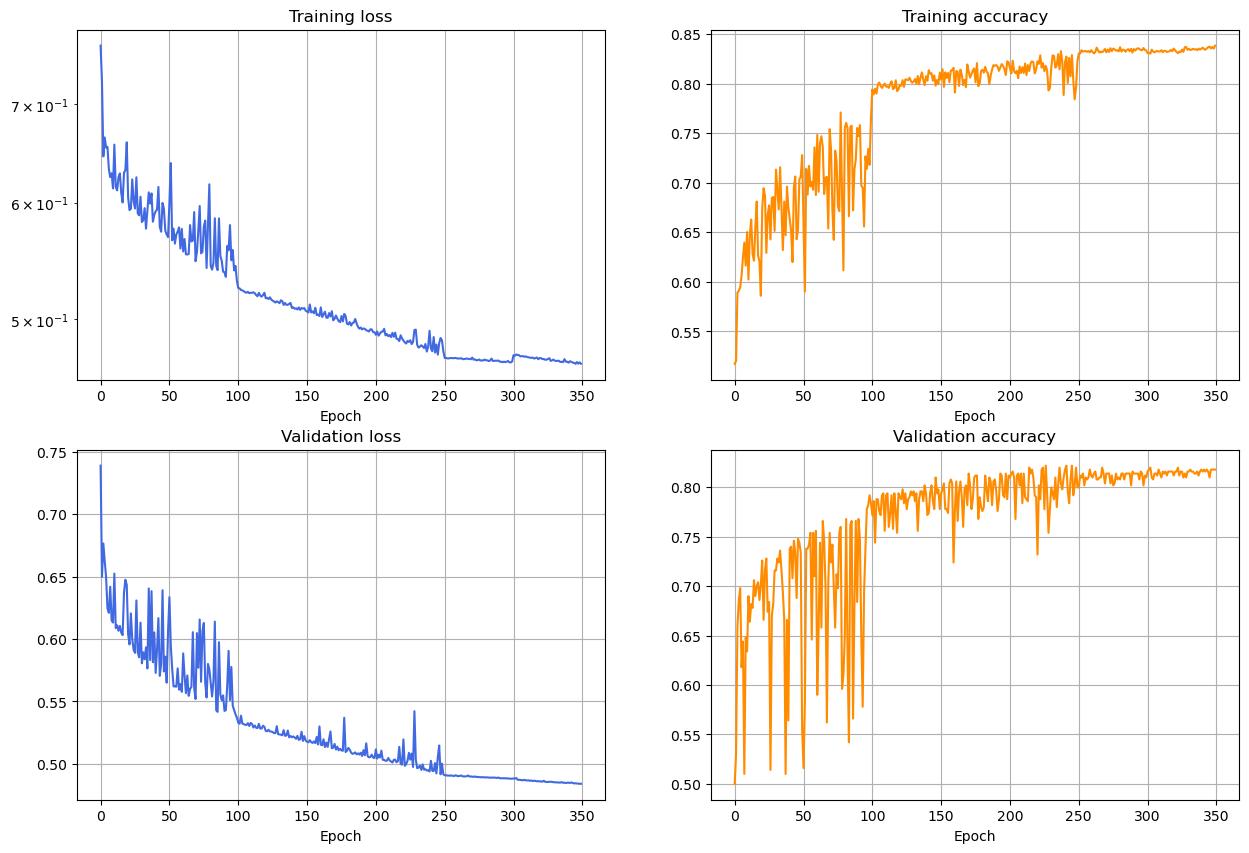

In [143]:
# plot training/validation loss and accuracy over training time
model_12.plot_model_results()

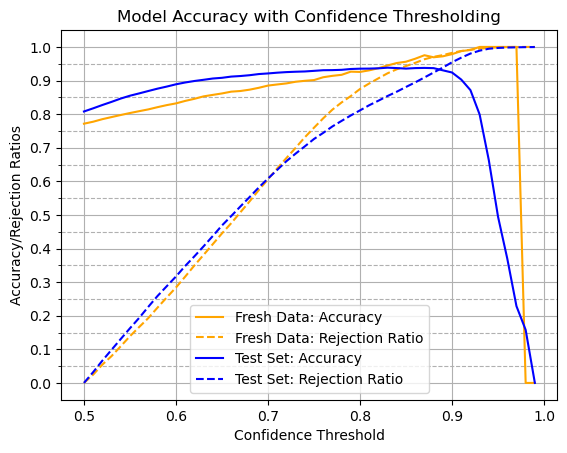

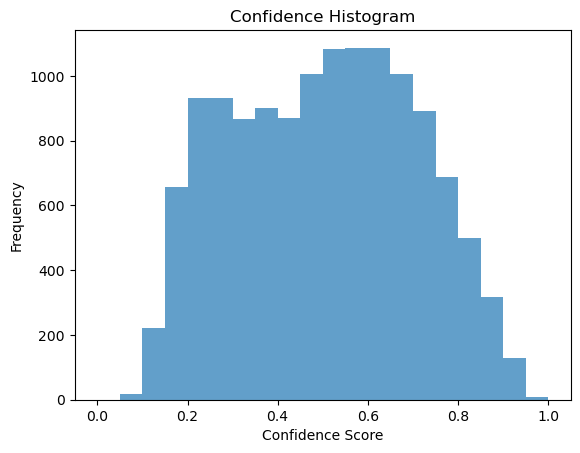

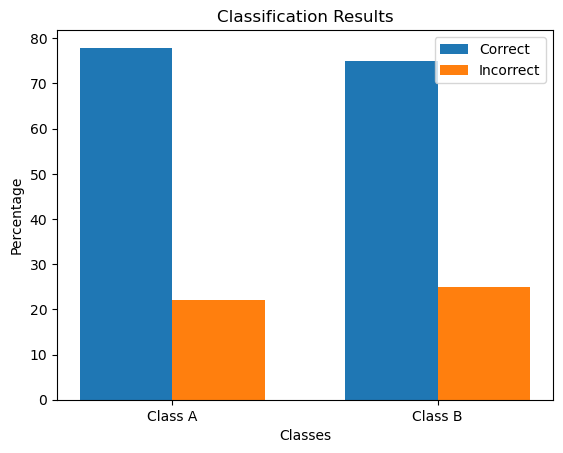

In [144]:
model_12.plot_confidence_thresholding([['Fresh Data', PSF_good_testing], ['Test Set', PSF_testing]])
model_12.confidence_histogram(PSF_good_testing)
model_12.plot_classification_results(PSF_good_testing)

In [150]:
model_12.save_model('Models/model12.pt')